In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy import signal
from math import exp
import processes.foundation as fd
from math import exp, sqrt, pi, erfc
from lmfit import Model
import csv
from scipy.optimize import curve_fit
import pywt
from statistics import median
import copy

In [2]:
def find_closest_idx(arr, val):
       idx = np.abs(arr - val).argmin()
       return idx

In [3]:
def find_idx(arr, val, idxBegin):
        for i in range(idxBegin, 0, -1):
            count = arr[i]
            if count <= val:
                break

        idx = i
        return idx

In [4]:
def find_idxr(arr, val, idxBegin):
        for i in range(idxBegin, len(arr)-1, 1):
            count = arr[i]
            if count >= val:
                break
        
        idx = i
        return idx

In [5]:
def pulsar(riseMax,riseMin, E90, EMin):
    rise = int((riseMax-riseMin)*np.random.random()+riseMin)
    energy = (E90-EMin)*np.random.random()+EMin

    pulse = np.zeros(15000)
    x = np.linspace(0,rise+10,rise+11)
    y = x*(energy/rise) + 0

    pulse[10000: 10000+len(x)] = y
    pulse[10000+len(x)::] = np.ones(15000-10000-len(x))*y[-1]

    return pulse, rise, energy

In [6]:
def sigPulse(riseMax,riseMin, E90, EMin):
    rise = int((riseMax-riseMin)*np.random.random()+riseMin)
    energy = (E90-EMin)*np.random.random()+EMin



    pulse = np.zeros(15000)
    x = np.linspace(-rise-40,rise+40,2*rise+81)
    y = energy/(1 + np.exp(-x/(0.3*rise)))

    pulse[10000: 10000+len(x)] = y
    pulse[10000+len(x)::] = y[-1]

    max = np.amax(pulse)
    min = np.amin(pulse)
    m90 = max - (max-min)*0.10
    m10 = max - (max-min)*0.90
    imax9 = find_closest_idx(pulse, m90)
    imax1 = find_closest_idx(pulse, m10)
    rise = imax9 - imax1

    return pulse, rise, energy

In [7]:
def sigPulseSpecific(riseMax, riseMin, Energy):
    rise = int((riseMax-riseMin)*np.random.random()+riseMin)
    energy = Energy



    pulse = np.zeros(15000)
    x = np.linspace(-rise-40,rise+40,2*rise+81)
    y = energy/(1 + np.exp(-x/(0.3*rise)))

    pulse[10000: 10000+len(x)] = y
    pulse[10000+len(x)::] = y[-1]

    max = np.amax(pulse)
    min = np.amin(pulse)
    m90 = max - (max-min)*0.10
    m10 = max - (max-min)*0.90
    imax9 = find_closest_idx(pulse, m90)
    imax1 = find_closest_idx(pulse, m10)
    rise = imax9 - imax1

    return pulse, rise

In [8]:
def checkRise(rise_true, rise_cal, energy, eps, correct, false, Emin, Emax, Nb):
    steps = (Emax - Emin)/Nb
    bins = np.arange(Emin,Emax,steps)
    if abs(rise_true-rise_cal) <= eps:
        for j in range(0, len(bins)-1):
            if energy >= bins[j] and energy <= bins[j+1]:
                correct[j] += 1
    else:
        for j in range(0, len(bins)-1):
            if energy >= bins[j] and energy <= bins[j+1]:
                false[j] += 1
    return correct, false

In [46]:
#Here is Method 1 which calculates the rise time by subtracting off the specific value and findes the index with the value closest to 0.
#Method 1 also uses an RNG pulsar.
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")

Emin = 100
Emax = 1000
steps = 100000
nb = 10000
rise_true = np.zeros(steps)
rise_cal = np.zeros(steps)
energy_true = np.zeros(steps)
#correct = np.zeros(nb)
#false = np.zeros(nb)
deltat = np.zeros(steps)
cDs = pywt.swt(wave, "haar", level=4)
threshold = np.zeros_like([0,0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")
#"""
for i in range(0,steps):
    pulse, rise_true[i], energy_true[i] = pulsar(70,50,Emax,Emin)
    wave1 = copy.deepcopy(wave)
    wp = wave1[0:15000] + pulse
    max = np.amax(wp)
    min = np.amin(wp)
    m90 = max - (max-min)*0.10
    m10 = max - (max-min)*0.90
    imax9 = find_closest_idx(wp, m90)
    imax1 = find_closest_idx(wp, m10)
    rise_cal[i] = imax9 - imax1
    deltat[i] = rise_cal[i] - rise_true[i]

    #correct, false = checkRise(rise_true[i], rise_cal[i], energy_true[i], 10, correct, false, Emin, Emax, nb)
#"""
    
    


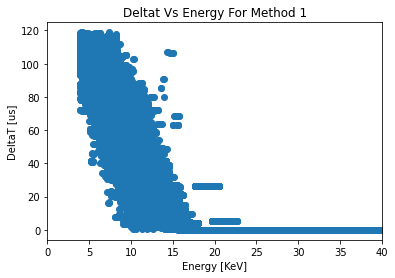

In [47]:
plt.scatter(energy_true*0.0408625 -0.16892, deltat*.008)
plt.xlim(0, 40)
plt.xlabel("Energy [KeV]")
plt.ylabel("DeltaT [us]")
plt.title("Deltat Vs Energy For Method 1")
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.savefig("images/riseTimeMethod1.pdf", facecolor = "white")
plt.show()

In [48]:
#Here is Method 2 which calculates the rise time by using a starting index and going left till it finds a threshold.
#Method 1 also uses an RNG pulsar.
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")

energy_Step = 1000
steps = 100

run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[0]

cDs = pywt.swt(wave, "haar", level=4)
threshold = np.zeros_like([0,0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")
#"""
for i in range(0,steps):
    pulse, rise_true[i], energy_true[i] = pulsar(70,50,Emax,Emin)
    wave1 = copy.deepcopy(wave)
    wp = wave1[0:15000] + pulse
    max = np.amax(wp)
    min = np.amin(wp)
    m90 = max - (max-min)*0.10
    m10 = max - (max-min)*0.90
    imax9 = find_idx(wp, m90, np.argmax(wp))
    imax1 = find_idx(wp, m10, imax9)
    rise_cal[i] = imax9 - imax1
    deltat[i] = rise_cal[i] - rise_true[i]

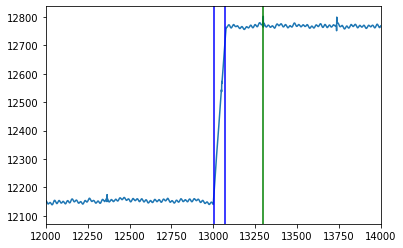

In [42]:
plt.plot(wp)
plt.axvline(x = np.argmax(wp), color='g', label = 'window_1')
plt.axvline(x = imax9, color='b', label = 'window_1')
plt.axvline(x = imax1, color='b', label = 'window_1')
plt.xlim(12000, 14000)
plt.show()

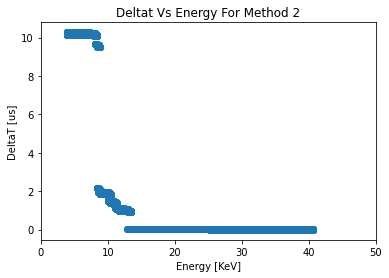

In [49]:
plt.scatter(energy_true*0.0408625 -0.16892, deltat*.008)
plt.xlim(0, 50)
plt.xlabel("Energy [KeV]")
plt.ylabel("DeltaT [us]")
plt.title("Deltat Vs Energy For Method 2")
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.savefig("images/riseTimeMethod2.pdf", facecolor = "white")
plt.show()

In [344]:
#Here is Method 2 which calculates the rise time by using a starting index and going left till it finds a threshold.
#Method 1 also uses an RNG sigmoid pulsar.
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")

Emin = 10
Emax = 800
steps = 100000
nb = 10000
rise_true = np.zeros(steps)
rise_cal = np.zeros(steps)
energy_true = np.zeros(steps)
#correct = np.zeros(nb)
#false = np.zeros(nb)
deltat = np.zeros(steps)

run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[0]

cDs = pywt.swt(wave, "haar", level=4)
threshold = np.zeros_like([0,0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")

mean = np.nan
stdev = np.nan
slope = np.nan
intercept = np.nan


sum_x = sum_x2 = sum_xy = sum_y = mean = stdev = 0
isum = 15000

for i in range(0, 15000, 1):
    # the mean and standard deviation
        temp = wave[i] - mean
        mean += temp / (i + 1)
        stdev += temp * (wave[i] - mean)

        # linear regression
        sum_x += i
        sum_x2 += i * i
        sum_xy += wave[i] * i
        sum_y += wave[i]

slope = (isum * sum_xy - sum_x * sum_y) / (isum * sum_x2 - sum_x * sum_x)
intercept = (sum_y - sum_x * slope) / isum

line = np.array([x * slope + intercept for x in range(0, len(wave))])
wave = wave - line
#"""
for i in range(0,steps):
    pulse, rise_true[i], energy_true[i] = sigPulse(70,50,Emax,Emin)
    wave1 = copy.deepcopy(wave)
    wp = wave1[0:15000] + pulse
    wp = wp - np.mean(wp[0:1000])
    max = np.mean(wp[11000:15000])
    min = np.amin(wp)
    m90 = max*0.9
    m10 = max*0.1
    m50 = max*0.5
    imax51 = find_idx(wp, m50, 11000)
    imax9 = find_idxr(wp, m90, imax51)
    imax1 = find_idx(wp, m10, imax51)
    rise_cal[i] = imax9 - imax1
    deltat[i] = abs(rise_cal[i] - rise_true[i])

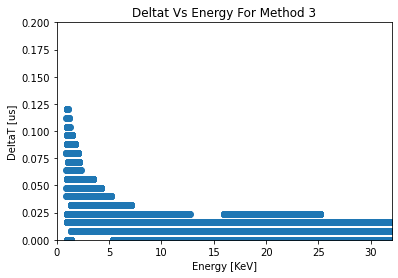

In [345]:
plt.scatter(energy_true*0.0408625 -0.16892, deltat*.008)
plt.xlim(0, 32)
plt.ylim(0.0,0.2)
plt.xlabel("Energy [KeV]")
plt.ylabel("DeltaT [us]")
plt.title("Deltat Vs Energy For Method 3")
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.savefig("images/riseTimeMethod3.pdf", facecolor = "white")
plt.show()

In [47]:
#Here is Method 2 which calculates the rise time by using a starting index and going left till it finds a threshold.
#Method 1 also uses an RNG sigmoid pulsar.
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")

energy_Step = 1000
steps = 100
nb = 10000
energy_lis = np.linspace(10,1250,energy_Step)
sig = np.zeros(energy_Step)
#correct = np.zeros(nb)
#false = np.zeros(nb)

run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[0]

cDs = pywt.swt(wave, "haar", level=4)
threshold = np.zeros_like([0,0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")

mean = np.nan
stdev = np.nan
slope = np.nan
intercept = np.nan


sum_x = sum_x2 = sum_xy = sum_y = mean = stdev = 0
isum = 15000

for i in range(0, 15000, 1):
    # the mean and standard deviation
        temp = wave[i] - mean
        mean += temp / (i + 1)
        stdev += temp * (wave[i] - mean)

        # linear regression
        sum_x += i
        sum_x2 += i * i
        sum_xy += wave[i] * i
        sum_y += wave[i]

slope = (isum * sum_xy - sum_x * sum_y) / (isum * sum_x2 - sum_x * sum_x)
intercept = (sum_y - sum_x * slope) / isum

line = np.array([x * slope + intercept for x in range(0, len(wave))])
wave = wave - line

j = 0
for energy in energy_lis:
    deltat = np.zeros(steps)
    rise_true = np.zeros(steps)
    rise_cal = np.zeros(steps)
    for i in range(0,steps):
        pulse, rise_true[i] = sigPulseSpecific(70,50,energy)
        wave1 = copy.deepcopy(wave)
        wp = wave1[0:15000] + pulse
        wp = wp - np.mean(wp[0:1000])
        max = np.mean(wp[11000:15000])
        min = np.amin(wp)
        m90 = max*0.9
        m10 = max*0.1
        m50 = max*0.5
        imax51 = find_idx(wp, m50, 11000)
        imax9 = find_idxr(wp, m90, imax51)
        imax1 = find_idx(wp, m10, imax51)
        rise_cal[i] = imax9 - imax1
        deltat[i] = abs(rise_cal[i] - rise_true[i])
    
    mean = sum(deltat)/len(deltat)
    variance = sum([((x - mean) ** 2) for x in deltat]) / len(deltat)
    sig[j] = variance ** 0.5
    j += 1


In [46]:
print(sig)

[0. 0. 0. ... 0. 0. 0.]


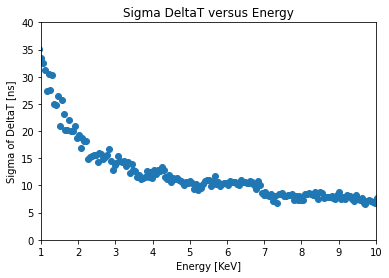

In [22]:
plt.scatter(energy_lis*0.0408625 -0.16892, sig*8)
plt.xlim(1,10)
plt.ylim(0,40)
plt.xlabel("Energy [KeV]")
plt.ylabel("Sigma of DeltaT [ns]")
plt.title("Sigma DeltaT versus Energy")
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.savefig("images/sigTimeEnergyRange.pdf", facecolor = "white")
plt.show()

In [72]:
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")

energy_Step = 1000
steps = 100
nb = 10000
energy_lis = np.linspace(10,1250,energy_Step)
sig = np.zeros(energy_Step)
#correct = np.zeros(nb)
#false = np.zeros(nb)

run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[0]

cDs = pywt.swt(wave, "haar", level=4)
threshold = np.zeros_like([0,0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")

mean = np.nan
stdev = np.nan
slope = np.nan
intercept = np.nan


sum_x = sum_x2 = sum_xy = sum_y = mean = stdev = 0
isum = 15000

for i in range(0, 15000, 1):
    # the mean and standard deviation
        temp = wave[i] - mean
        mean += temp / (i + 1)
        stdev += temp * (wave[i] - mean)

        # linear regression
        sum_x += i
        sum_x2 += i * i
        sum_xy += wave[i] * i
        sum_y += wave[i]

slope = (isum * sum_xy - sum_x * sum_y) / (isum * sum_x2 - sum_x * sum_x)
intercept = (sum_y - sum_x * slope) / isum

line = np.array([x * slope + intercept for x in range(0, len(wave))])
wave = wave - line

energy = 20

pulse, rise_true = sigPulseSpecific(70,50,energy)
wave1 = copy.deepcopy(wave)
wp = wave1[0:15000] + pulse
wp = wp - np.mean(wp[0:1000])
max = np.mean(wp[11000:15000])
min = np.amin(wp)
m90 = max*0.9
m10 = max*0.1
m50 = max*0.5
imax51 = find_idx(wp, m50, 11000)
imax9 = find_idxr(wp, m90, imax51)
imax1 = find_idx(wp, m10, imax51)
rise_cal = imax9 - imax1
deltat = abs(rise_cal - rise_true)

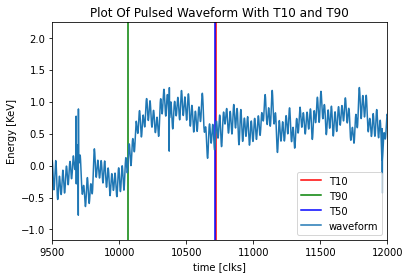

In [73]:
plt.axvline(x = imax9, color='r', label = 'T10')
plt.axvline(x = imax1, color='g', label = 'T90')
plt.axvline(x = imax51, color='b', label = 'T50')
plt.plot(wp*0.0408625 -0.16892, label="waveform")
plt.legend()
plt.xlim(9500,12000)
plt.xlabel("time [clks]")
plt.ylabel("Energy [KeV]")
plt.title("Plot Of Pulsed Waveform With T10 and T90")
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.savefig("images/PulsedWaveform1KeV.pdf", facecolor = "white")
plt.show()

In [164]:
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[1]

cDs = pywt.swt(wave, "haar", level=4)
threshold = np.zeros_like([0,0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")

temp = wave/np.linalg.norm(wave)

wp, energy_true[i] = pulsarTemp(Emax,Emin, temp)
#wave1 = copy.deepcopy(wave)
#wp = wave1[0:15000] + pulse
wp = wp - np.mean(wp[0:1000])

w_trap = np.zeros(len(wp))

rise = int(6/.008)
flat = int(0.8/.008)

w_trap[0] = wp[0]/rise
for i in range(1, rise, 1):
    w_trap[i] = w_trap[i - 1] + wp[i] / rise
for i in range(rise, rise + flat, 1):
    w_trap[i] = w_trap[i - 1] + (wp[i] - wp[i - rise])/rise
for i in range(rise + flat, 2 * rise + flat, 1):
    w_trap[i] = w_trap[i - 1] + (wp[i] - wp[i - rise] - wp[i - rise - flat])/rise
for i in range(2 * rise + flat, len(wp), 1):
    w_trap[i] = (
        w_trap[i - 1]
        + (wp[i]
        - wp[i - rise]
        - wp[i - rise - flat]
        + wp[i - 2 * rise - flat])/rise
    )

max = np.amax(w_trap)
min = np.amin(w_trap)
m90 = max - (max-min)*0.10
m10 = max - (max-min)*0.995
imax9 = find_idx(w_trap, m90, np.argmax(w_trap))
imax1 = find_idx(w_trap, m10, imax9)

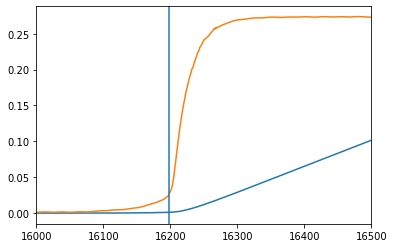

In [170]:
plt.plot(w_trap)
plt.plot(wp)
plt.axvline(x=imax1)
plt.xlim(16000,16500)
plt.show()

In [125]:
wave = data[0]["waveform"]["values"].nda[4]/np.linalg.norm(data[0]["waveform"]["values"].nda[4])

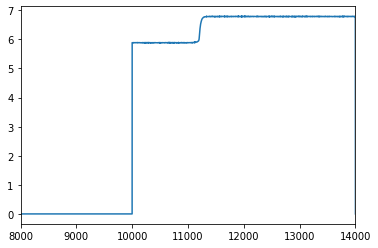

In [158]:
temp = data[0]["waveform"]["values"].nda[4]/np.linalg.norm(data[0]["waveform"]["values"].nda[4])
energy = (1000-100)*np.random.random()+100
temp = temp*energy
pulse = np.zeros(15000)
pulse[10000:14000] = pulse[10000:14000] + temp[15000:19000]
plt.plot(pulse)
plt.xlim(8000, 14000)
pulse[14001::] = pulse[12000]
plt.show()


(15000.0, 19000.0)

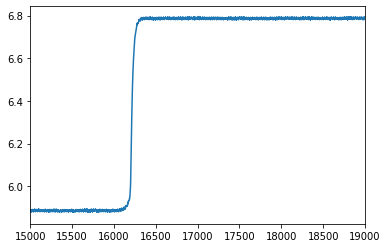

In [159]:
plt.plot(temp)
plt.xlim(15000, 19000)

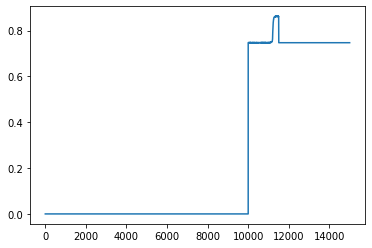

In [150]:
plt.plot(pulse)

(16200.0, 16300.0)

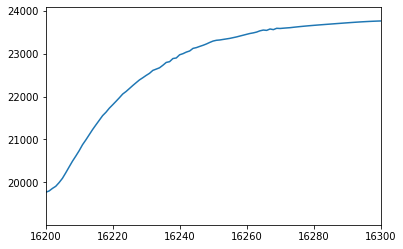

In [172]:
plt.plot(wave)
plt.xlim(16200, 16300)

In [107]:
l = len(data1[0]["waveform"]["values"].nda) + len(data2[0]["waveform"]["values"].nda) + len(data3[0]["waveform"]["values"].nda) + len(data4[0]["waveform"]["values"].nda) + len(data5[0]["waveform"]["values"].nda)
rise_time = np.zeros(l)

In [109]:

for i,wave in enumerate(data1[0]["waveform"]["values"].nda):
    j = i + len(data1[0]["waveform"]["values"].nda)
    max = np.amax(wave)
    min = np.amin(wave)
    m90 = max - (max-np.amin(wave))*0.10
    m10 = max - (max-np.amin(wave))*0.90
    imax9 = find_closest_idx(wave, m90)
    imax1 = find_closest_idx(wave, m10)
    rise_time[j] = imax9 - imax1

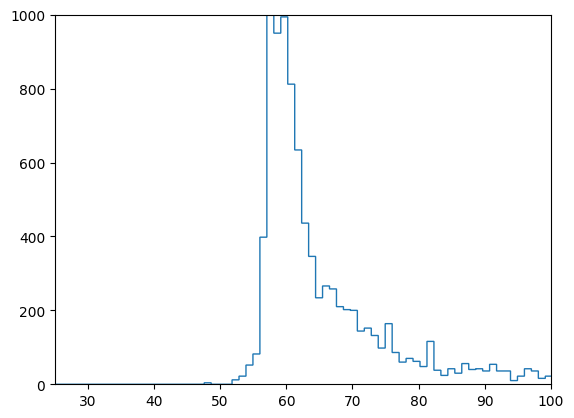

In [111]:
plt.hist(rise_time, histtype="step", bins = 20000)
plt.xlim(25,100)
plt.ylim(0,1000)
plt.show()

61


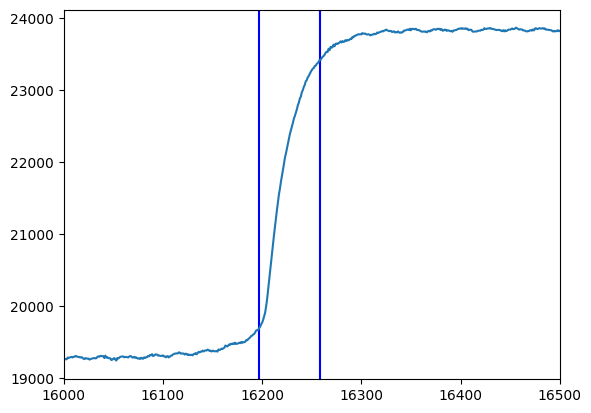

In [90]:
max = np.amax(wave)
min = np.amin(wave)
m90 = max - (max-np.amin(wave))*0.10
m10 = max - (max-np.amin(wave))*0.90
imax9 = find_closest_idx(wave, m90)
imax1 = find_closest_idx(wave, m10)
plt.axvline(x = imax9, color='b', label = 'window_1')
plt.axvline(x = imax1, color='b', label = 'window_1')
plt.plot(wave)
plt.xlim(16000,16500)
plt.show()

In [331]:
rise = int((70-50)*np.random.random()+50)
energy = (1000-100)*np.random.random()+100

pulse = np.zeros(15000)
x = np.linspace(-rise-40,rise+40,2*rise+81)
y = 25/(1 + np.exp(-x/(0.3*rise)))

pulse[10000: 10000+len(x)] = y
pulse[10000+len(x)::] = y[-1]
print(rise)

55


11002
10998
21.40326477173415


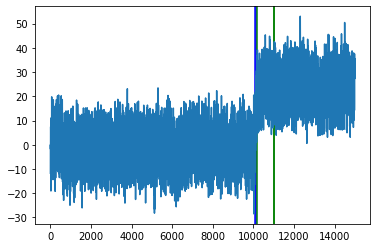

In [332]:
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[1][0:15000]

cDs = pywt.swt(wave, "haar", level=3)
threshold = np.zeros_like([0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")

max = np.amax(pulse)
min = np.amin(pulse)
m90 = max - (max-np.amin(pulse))*0.10
m10 = max - (max-np.amin(pulse))*0.90
imax9 = find_closest_idx(pulse, m90)
imax1 = find_closest_idx(pulse, m10)
wave1 = copy.deepcopy(wave)
mean = np.nan
stdev = np.nan
slope = np.nan
intercept = np.nan


sum_x = sum_x2 = sum_xy = sum_y = mean = stdev = 0
isum = 15000

for i in range(0, 15000, 1):
    # the mean and standard deviation
        temp = wave1[i] - mean
        mean += temp / (i + 1)
        stdev += temp * (wave1[i] - mean)

        # linear regression
        sum_x += i
        sum_x2 += i * i
        sum_xy += wave1[i] * i
        sum_y += wave1[i]

slope = (isum * sum_xy - sum_x * sum_y) / (isum * sum_x2 - sum_x * sum_x)
intercept = (sum_y - sum_x * slope) / isum

line = np.array([x * slope + intercept for x in range(0, len(wave1))])
wave1 = wave1 - line
wp = wave1[0:15000] + pulse
wp = wp - np.mean(wp[0:1000])
max = np.mean(wp[11000:15000])
min = np.amin(wp)
m90 = max*0.9
m10 = max*0.1
m50 = max*0.5
imax51 = find_idx(wp, m50, 11000)
imax91 = find_idxr(wp, m90, imax51)
imax11 = find_idx(wp, m10, imax51)
print(imax91)
print(imax51)
print(m90)
plt.axvline(x = imax9, color='b', label = 'window_1')
plt.axvline(x = imax1, color='b', label = 'window_1')
plt.axvline(x = imax51, color='g', label = 'window_1')
plt.axvline(x = imax11, color='g', label = 'window_1')
plt.axvline(x = imax91, color='g', label = 'window_1')
plt.plot(wp)
plt.show()

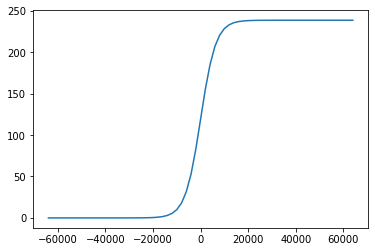

In [207]:
plt.plot(x, y)

0.0015065577874242271
19255.5883711753


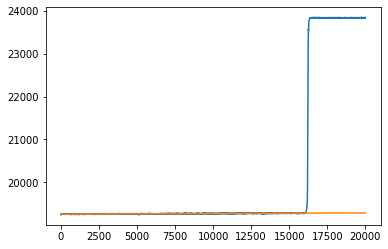

In [271]:
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[1]

cDs = pywt.swt(wave, "haar", level=4)
threshold = np.zeros_like([0,0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")

max = np.amax(pulse)
min = np.amin(pulse)
m90 = max - (max-np.amin(pulse))*0.10
m10 = max - (max-np.amin(pulse))*0.90
imax9 = find_closest_idx(pulse, m90)
imax1 = find_closest_idx(pulse, m10)
wave1 = copy.deepcopy(wave)
mean = np.nan
stdev = np.nan
slope = np.nan
intercept = np.nan


sum_x = 0
sum_x2 = 0
sum_xy = 0
sum_y = 0
mean = 0
stdev = 0
isum = 15000

for i in range(0, 15000, 1):
    # the mean and standard deviation
        temp = wave1[i] - mean
        mean += temp / (i + 1)
        stdev += temp * (wave1[i] - mean)

        # linear regression
        sum_x += i
        sum_x2 += i * i
        sum_xy += wave1[i] * i
        sum_y += wave1[i]

slope = (isum * sum_xy - sum_x * sum_y) / (isum * sum_x2 - sum_x * sum_x)
intercept = (sum_y - sum_x * slope) / isum

print(slope)
print(intercept)

line = np.array([x * slope + intercept for x in range(0, len(wave1))])
wave1 = wave1 - line
plt.plot(wave)
plt.plot(line)
plt.show()

In [327]:
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[1][0:15000]

cDs = pywt.swt(wave, "haar", level=3)
threshold = np.zeros_like([0,0,0])

j=0
for cD in cDs:
    median_value = median(cD[1])
    median_average_deviation = median([abs(number-median_value) for number in cD[1]])
    sig1 = median_average_deviation/0.6745
    threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
    j+=1

j=0
for cD in cDs:
    cD[1][abs(cD[1]) < threshold[j]] = 0.0
    j += 1

wave = pywt.iswt(cDs, "Haar")

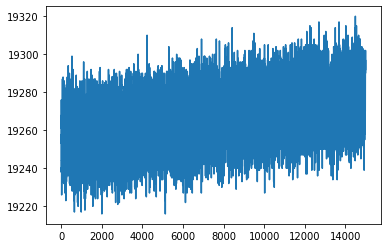

In [330]:
run_list = 9188
data = fd.get_t1_data(run_list, "Card1")
wave = data[0]["waveform"]["values"].nda[1][0:15000]
plt.plot(wave)

In [368]:
from numpy import int64


df = pd.DataFrame(data[0]["timestamp"].nda, dtype=int64)
df.columns = ["Timestamp"]

In [378]:
df = df[df["Timestamp"] > 0]

In [372]:
print(data[0]["channel"])

[0 0 0 ... 0 0 0]


In [370]:
deltaT = np.zeros(len(df["Timestamp"]))
for i in range(0,len(df["Timestamp"])-1):
    deltaT[i] = df["Timestamp"].iloc[i+1] - df["Timestamp"].iloc[i]
    print(deltaT[i])

579900.0
0.0
-7457502009.0
145361.0
127554596179198.0
-127547137770185.0
0.0
-7458554374.0
145361.0
127554596179198.0
-161806772310837.0
0.0
34259635055544.0
432742.0
99060.0
447972.0
60048.0
689159.0
0.0
-1296239.0
99060.0
127547136723491.0
-161806772310837.0
34259637633622.0
58564.0
221449.0
223804.0
135975.0
684747.0
0.0
-684747.0
-359779.0
127547134397202.0
-161806772310837.0
34259639590931.0
250655.0
119557.0
69766.0
-69766.0
69766.0
-2117274.0
127547134397202.0
-161806772310837.0
34259639961143.0
69766.0
-2117274.0
127547134397202.0
-127547130931511.0
185776.0
491557.0
92481.0
-92481.0
92481.0
-4235505.0
127547134397202.0
-127547130254178.0
92481.0
-4235505.0
127547134397202.0
-127547130254178.0
92481.0
-4235505.0
127547134397202.0
-127547128348753.0
0.0
-1812944.0
-4235505.0
127547134397202.0
-161806772310837.0
0.0
34259644878124.0
167824.0
-167824.0
167824.0
-7132313.0
127547134397202.0
-127547126105537.0
51669.0
83865.0
25962.0
353227.0
280668.0
-280668.0
280668.0
-633895.0
12

In [371]:
print(df["Timestamp"].iloc[4])
print(df["Timestamp"].iloc[3])

34252176131639
34252175986278


In [367]:
df["Timestamp"].iloc[2] - df["Timestamp"].iloc[3]

7457502009

In [25]:
data2 = data2[data2["timestamp"] > 0]

(array([6147.,    0.,    0., ...,    0.,    0., 2235.]),
 array([0.00000000e+00, 1.84467441e+16, 3.68934881e+16, ...,
        1.84098506e+19, 1.84282973e+19, 1.84467441e+19]),
 <BarContainer object of 1000 artists>)

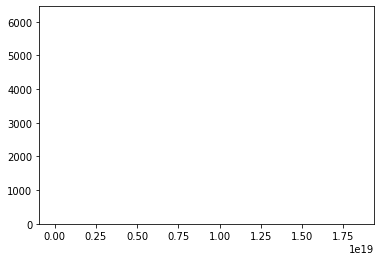

In [359]:
plt.hist(deltaT,1000)

In [67]:
data = fd.get_t1_data(1365, "Card1")
data2 = fd.get_df(1365, "Card1")

In [9]:
rise_time = np.zeros(len(data[0]["waveform"]["values"].nda))
for n, wave in enumerate(data[0]["waveform"]["values"].nda):
    cDs = pywt.swt(wave, "haar", level=4)
    threshold = np.zeros_like([0,0,0,0])

    j=0
    for cD in cDs:
        median_value = median(cD[1])
        median_average_deviation = median([abs(number-median_value) for number in cD[1]])
        sig1 = median_average_deviation/0.6745
        threshold[j] = sig1*np.sqrt(2*np.log(len(wave)))
        j+=1

    j=0
    for cD in cDs:
        cD[1][abs(cD[1]) < threshold[j]] = 0.0
        j += 1

    wave = pywt.iswt(cDs, "Haar")

    mean = np.nan
    stdev = np.nan
    slope = np.nan
    intercept = np.nan


    sum_x = sum_x2 = sum_xy = sum_y = mean = stdev = 0
    isum = 15000

    for i in range(0, 15000, 1):
    # the mean and standard deviation
        temp = wave[i] - mean
        mean += temp / (i + 1)
        stdev += temp * (wave[i] - mean)

        # linear regression
        sum_x += i
        sum_x2 += i * i
        sum_xy += wave[i] * i
        sum_y += wave[i]

    slope = (isum * sum_xy - sum_x * sum_y) / (isum * sum_x2 - sum_x * sum_x)
    intercept = (sum_y - sum_x * slope) / isum

    line = np.array([x * slope + intercept for x in range(0, len(wave))])
    wave = wave - line

    max = np.mean(wave[17000:20000])
    min = np.amin(wave)
    m90 = max*0.9
    m10 = max*0.1
    m50 = max*0.5
    imax51 = find_idx(wave, m50, 17000)
    imax9 = find_idxr(wave, m90, imax51)
    imax1 = find_idx(wave, m10, imax51)
    rise_time[n] = imax9 - imax1
    

In [54]:
data2["energy"] = data2["trapEmax"]*0.0408625 -0.16892

In [15]:
from matplotlib import colors

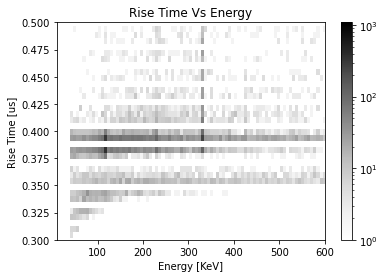

In [25]:
plt.hist2d(data2["energy"], rise_time*.008, bins=(400,8000),norm = colors.LogNorm(), cmap=plt.cm.Greys)
plt.ylim(0.3,0.5)
plt.xlim(10,600)
plt.colorbar()
plt.xlabel("Energy [KeV]")
plt.ylabel("Rise Time [us]")
plt.title("Rise Time Vs Energy")
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.savefig("images/riseTimeVsEnergyLogFine.pdf", facecolor = "white")
plt.show()

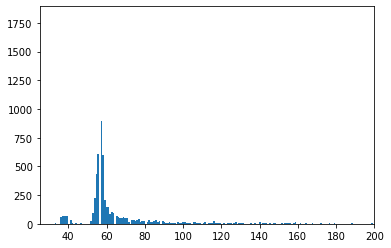

In [23]:
plt.hist(rise_time, bins=4000)
plt.xlim(25,200)
plt.show()

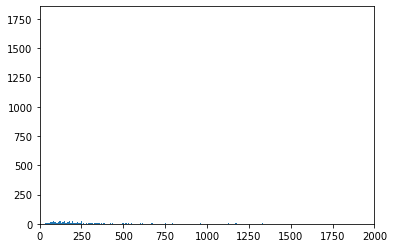

In [16]:
plt.hist(data2["energy"], bins=4000)
plt.xlim(0,2000)
plt.show()

In [69]:
data2 = data2[data2["timestamp"] > 0]

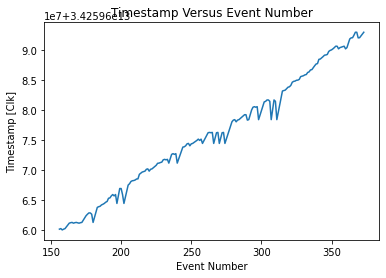

In [38]:
plt.plot(data2["timestamp"][125:300])
plt.xlabel("Event Number")
plt.ylabel("Timestamp [Clk]")
plt.title("Timestamp Versus Event Number")
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.savefig("images/normalTimestamp.pdf", facecolor = "white")
plt.show()

In [59]:
data2["timestamp"]

0        190650481392
1        190650559413
2        190651532316
3        190651731486
4        190652979934
             ...     
25395    198275635512
25396    198276000389
25397    198276077210
25398    198276100621
25399    198276566434
Name: timestamp, Length: 25400, dtype: uint64

In [70]:
df = data2.drop_duplicates("timestamp")

In [66]:
(len(data2["timestamp"]) - len(df["timestamp"]))/len(data2["timestamp"])

0.1423228346456693

In [71]:
(len(data2["timestamp"]) - len(df["timestamp"]))/len(data2["timestamp"])

0.1037603883814696

In [65]:
len(df["timestamp"])

21785